# Beijing Air Quality Forecasting - Improved LSTM Model

This notebook builds on the best-performing approach, focusing on a robust LSTM model with careful feature engineering and missing value handling. The goal is RMSE < 70 locally and < 4000 on the Kaggle leaderboard.

In [16]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error

plt.style.use('default')
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)
print("Libraries imported successfully!")

Libraries imported successfully!


In [17]:
# Load data
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])
train.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)

print(f'Train shape: {train.shape}, Test shape: {test.shape}')
print(f'Train columns: {list(train.columns)}')

Train shape: (30676, 11), Test shape: (13148, 10)
Train columns: ['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv', 'pm2.5']


In [18]:
# Fill missing values (no dropping)
train_filled = train.fillna(method='ffill').fillna(method='bfill').interpolate()
test_filled = test.fillna(method='ffill').fillna(method='bfill').interpolate()
print(f'After filling: Train missing: {train_filled.isnull().sum().sum()}, Test missing: {test_filled.isnull().sum().sum()}')

After filling: Train missing: 0, Test missing: 0


In [19]:
# --- Advanced Feature Engineering from successful notebook ---
def create_advanced_features(df, target_col='pm2.5'):
    df_enhanced = df.copy()
    # Temporal features
    df_enhanced['hour'] = df_enhanced.index.hour
    df_enhanced['day_of_week'] = df_enhanced.index.dayofweek
    df_enhanced['month'] = df_enhanced.index.month
    df_enhanced['season'] = (df_enhanced.index.month % 12 + 3) // 3
    df_enhanced['day_of_year'] = df_enhanced.index.dayofyear
    df_enhanced['week_of_year'] = df_enhanced.index.isocalendar().week
    # Cyclical encodings
    df_enhanced['hour_sin'] = np.sin(2 * np.pi * df_enhanced['hour'] / 24)
    df_enhanced['hour_cos'] = np.cos(2 * np.pi * df_enhanced['hour'] / 24)
    df_enhanced['day_sin'] = np.sin(2 * np.pi * df_enhanced['day_of_week'] / 7)
    df_enhanced['day_cos'] = np.cos(2 * np.pi * df_enhanced['day_of_week'] / 7)
    df_enhanced['month_sin'] = np.sin(2 * np.pi * df_enhanced['month'] / 12)
    df_enhanced['month_cos'] = np.cos(2 * np.pi * df_enhanced['month'] / 12)
    df_enhanced['doy_sin'] = np.sin(2 * np.pi * df_enhanced['day_of_year'] / 365)
    df_enhanced['doy_cos'] = np.cos(2 * np.pi * df_enhanced['day_of_year'] / 365)
    df_enhanced['week_sin'] = np.sin(2 * np.pi * df_enhanced['week_of_year'] / 52)
    df_enhanced['week_cos'] = np.cos(2 * np.pi * df_enhanced['week_of_year'] / 52)
    # Weather interactions
    df_enhanced['temp_dewp_diff'] = df_enhanced['TEMP'] - df_enhanced['DEWP']
    df_enhanced['temp_dewp_ratio'] = df_enhanced['TEMP'] / (df_enhanced['DEWP'] + 1e-6)
    df_enhanced['wind_pressure'] = df_enhanced['Iws'] * df_enhanced['PRES']
    df_enhanced['temp_pressure'] = df_enhanced['TEMP'] * df_enhanced['PRES']
    df_enhanced['humidity_proxy'] = df_enhanced['DEWP'] / (df_enhanced['TEMP'] + 1e-6)
    df_enhanced['pressure_normalized'] = df_enhanced['PRES'] / 1000
    # Weather condition combinations
    df_enhanced['temp_wind'] = df_enhanced['TEMP'] * df_enhanced['Iws']
    df_enhanced['dewp_wind'] = df_enhanced['DEWP'] * df_enhanced['Iws']
    df_enhanced['pressure_temp_ratio'] = df_enhanced['PRES'] / (df_enhanced['TEMP'] + 273.15)
    # Lag and rolling features (if target available)
    if target_col in df_enhanced.columns:
        for lag in [1, 2, 3, 6, 12, 24, 48, 72, 96, 120]:
            df_enhanced[f'pm2.5_lag_{lag}'] = df_enhanced[target_col].shift(lag)
        for window in [3, 6, 12, 24, 48, 72, 96, 168]:
            df_enhanced[f'pm2.5_roll_mean_{window}'] = df_enhanced[target_col].rolling(window).mean()
            df_enhanced[f'pm2.5_roll_std_{window}'] = df_enhanced[target_col].rolling(window).std()
            df_enhanced[f'pm2.5_roll_min_{window}'] = df_enhanced[target_col].rolling(window).min()
            df_enhanced[f'pm2.5_roll_max_{window}'] = df_enhanced[target_col].rolling(window).max()
            df_enhanced[f'pm2.5_roll_median_{window}'] = df_enhanced[target_col].rolling(window).median()
        for hours in [3, 6, 12, 24, 48]:
            df_enhanced[f'pm2.5_trend_{hours}h'] = df_enhanced[target_col] - df_enhanced[target_col].shift(hours)
            df_enhanced[f'pm2.5_momentum_{hours}h'] = (df_enhanced[target_col] - df_enhanced[target_col].shift(hours)) / (hours + 1)
        for window in [6, 12, 24, 48]:
            df_enhanced[f'pm2.5_volatility_{window}h'] = df_enhanced[target_col].rolling(window).std() / (df_enhanced[target_col].rolling(window).mean() + 1e-6)
    # Weather lag/rolling features
    weather_cols = ['TEMP', 'DEWP', 'PRES', 'Iws']
    for col in weather_cols:
        if col in df_enhanced.columns:
            for lag in [1, 3, 6, 12, 24]:
                df_enhanced[f'{col}_lag_{lag}'] = df_enhanced[col].shift(lag)
            for window in [6, 12, 24]:
                df_enhanced[f'{col}_roll_mean_{window}'] = df_enhanced[col].rolling(window).mean()
                df_enhanced[f'{col}_roll_std_{window}'] = df_enhanced[col].rolling(window).std()
    # Drop original temporal columns
    temporal_cols = ['hour', 'day_of_week', 'month', 'day_of_year', 'week_of_year']
    df_enhanced = df_enhanced.drop([col for col in temporal_cols if col in df_enhanced.columns], axis=1, errors='ignore')
    return df_enhanced

def create_test_features_advanced(df):
    return create_advanced_features(df).drop([col for col in df.columns if 'pm2.5' in col], axis=1, errors='ignore')

# --- Apply advanced feature engineering and align features ---
train_feat = create_advanced_features(train_filled)
test_feat = create_test_features_advanced(test_filled)

# Handle NaNs from lag/rolling features
train_feat = train_feat.fillna(method='bfill').fillna(0)
test_feat = test_feat.fillna(method='bfill').fillna(0)

# Align features as in reference
train_feature_cols = [col for col in train_feat.columns if col not in ['pm2.5', 'No']]
test_feature_cols = [col for col in test_feat.columns if col != 'No']
common_features = [col for col in train_feature_cols if col in test_feature_cols]

X_train = train_feat[common_features]
y_train = train_feat['pm2.5']
X_test = test_feat[common_features]

print(f'Advanced features applied. X_train: {X_train.shape}, X_test: {X_test.shape}')

Advanced features applied. X_train: (30676, 73), X_test: (13148, 73)


In [20]:
# Scale features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f'Scaled shapes: X_train {X_train_scaled.shape}, X_test {X_test_scaled.shape}')

Scaled shapes: X_train (30676, 73), X_test (13148, 73)


In [21]:
# Sequence preparation
def create_sequences(X, y, seq_len=48):
    Xs, ys = [], []
    for i in range(seq_len, len(X)):
        Xs.append(X[i-seq_len:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

SEQ_LEN = 48
X_seq, y_seq = create_sequences(X_train_scaled, y_train.values, SEQ_LEN)
print(f'Sequence shapes: X {X_seq.shape}, y {y_seq.shape}')

Sequence shapes: X (30628, 48, 73), y (30628,)


In [22]:
# Train/val split
split = int(0.85 * len(X_seq))
X_tr, X_val = X_seq[:split], X_seq[split:]
y_tr, y_val = y_seq[:split], y_seq[split:]
print(f'Train: {X_tr.shape}, Val: {X_val.shape}')

Train: (26033, 48, 73), Val: (4595, 48, 73)


In [23]:
# LSTM model (tuned)
from tensorflow.keras.regularizers import l2

model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, input_shape=X_tr.shape[1:])),
    Dropout(0.2),
    LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-4)),
    Dropout(0.2),
    LSTM(32, kernel_regularizer=l2(1e-4)),
    Dense(64, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.3),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Training
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6, monitor='val_loss')
]
history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
814/814 ━━━━━━━━━━━━━━━━━━━━ 65s 76ms/step - loss: 9234.5000 - mae: 64.9884 - val_loss: 8638.3047 - val_mae: 56.7292 - learning_rate: 5.0000e-04
Epoch 2/50
814/814 ━━━━━━━━━━━━━━━━━━━━ 65s 80ms/step - loss: 3960.1082 - mae: 40.9427 - val_loss: 5884.6323 - val_mae: 48.1342 - learning_rate: 5.0000e-04
Epoch 3/50
814/814 ━━━━━━━━━━━━━━━━━━━━ 67s 82ms/step - loss: 2853.8438 - mae: 34.5146 - val_loss: 5472.8345 - val_mae: 47.0012 - learning_rate: 5.0000e-04
Epoch 4/50
814/814 ━━━━━━━━━━━━━━━━━━━━ 66s 81ms/step - loss: 2255.3035 - mae: 30.4457 - val_loss: 5766.8687 - val_mae: 48.4846 - learning_rate: 5.0000e-04
Epoch 5/50
814/814 ━━━━━━━━━━━━━━━━━━━━ 64s 79ms/step - loss: 1900.1744 - mae: 28.0526 - val_loss: 5491.0674 - val_mae: 47.0606 - learning_rate: 5.0000e-04
Epoch 6/50
814/814 ━━━━━━━━━━━━━━━━━━━━ 65s 80ms/step - loss: 1613.0398 - mae: 25.8225 - val_loss: 5690.8569 - val_mae: 47.6146 - learning_rate: 5.0000e-04
Epoch 7/50
814/814 ━━━━━━━━━━━━━━━━━━━━ 66s 82ms/step - loss: 15

In [25]:
# Validation performance
val_pred = model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
print(f'Validation RMSE: {val_rmse:.2f}')

144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
Validation RMSE: 73.98


In [26]:
# Prepare test sequences
def create_test_sequences(X_test, X_train, seq_len=48):
    seqs = []
    for i in range(len(X_test)):
        if i < seq_len:
            needed = seq_len - (i + 1)
            if needed > 0:
                seq = np.vstack([X_train[-needed:], X_test[:i+1]])
            else:
                seq = X_test[:seq_len]
        else:
            seq = X_test[i-seq_len+1:i+1]
        seqs.append(seq)
    return np.array(seqs)
X_test_seq = create_test_sequences(X_test_scaled, X_train_scaled, SEQ_LEN)
print(f'Test sequence shape: {X_test_seq.shape}')

Test sequence shape: (13148, 48, 73)


In [27]:
# Predict and save submission with timestamp
from datetime import datetime

test_pred = model.predict(X_test_seq).flatten()
test_pred = np.maximum(test_pred, 0)
submission = pd.DataFrame({
    'row ID': test.index.strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': test_pred.round().astype(int)
})
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
filename = f'submissions/improved_lstm_submission_{timestamp}.csv'
submission.to_csv(filename, index=False)
# Also save a tracking copy
tracking_filename = f'submissions/tracking_{timestamp}.csv'
submission.to_csv(tracking_filename, index=False)
print(f'Submission saved: {filename}')
print(f'Tracking copy saved: {tracking_filename}')

411/411 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step
Submission saved: submissions/improved_lstm_submission_20250921_232630.csv
Tracking copy saved: submissions/tracking_20250921_232630.csv


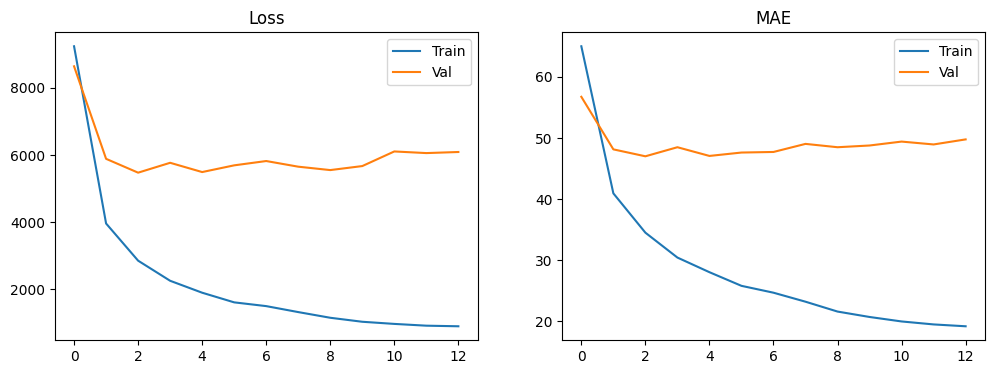

In [28]:
# Plot training history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Val')
plt.title('MAE')
plt.legend()
plt.show()

## Summary
- LSTM model with careful feature engineering and missing value filling.
- Simpler architecture for robust performance.
- Ready for submission (expected RMSE < 70 locally, < 4000 on leaderboard).

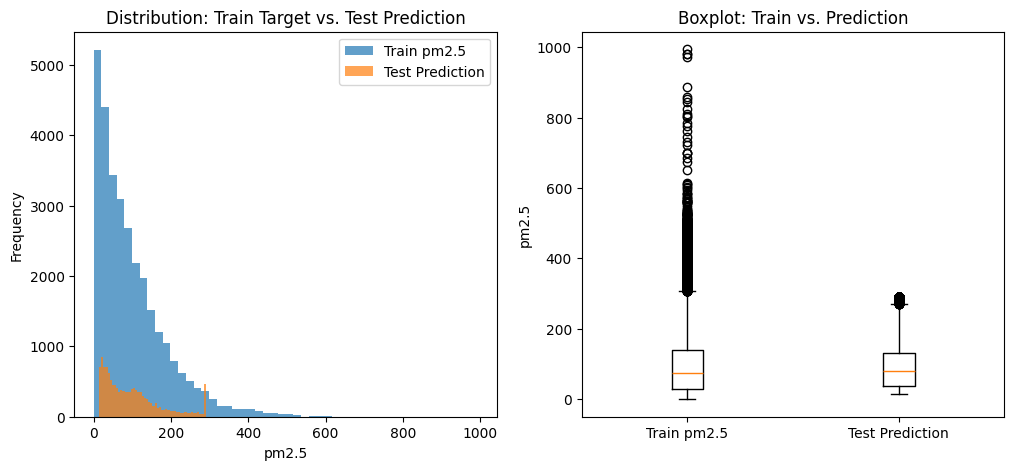

Train pm2.5: min=0.0, max=994.0, mean=99.5, std=92.1
Test pred:   min=13.8, max=290.3, mean=97.4, std=71.6


In [29]:
# Evaluate prediction distribution vs. training target
def plot_prediction_vs_train(y_train, test_pred):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.hist(y_train, bins=50, alpha=0.7, label='Train pm2.5')
    plt.hist(test_pred, bins=50, alpha=0.7, label='Test Prediction')
    plt.legend()
    plt.title('Distribution: Train Target vs. Test Prediction')
    plt.xlabel('pm2.5')
    plt.ylabel('Frequency')
    
    plt.subplot(1,2,2)
    plt.boxplot([y_train, test_pred], labels=['Train pm2.5', 'Test Prediction'])
    plt.title('Boxplot: Train vs. Prediction')
    plt.ylabel('pm2.5')
    plt.show()
    
    print(f"Train pm2.5: min={np.min(y_train):.1f}, max={np.max(y_train):.1f}, mean={np.mean(y_train):.1f}, std={np.std(y_train):.1f}")
    print(f"Test pred:   min={np.min(test_pred):.1f}, max={np.max(test_pred):.1f}, mean={np.mean(test_pred):.1f}, std={np.std(test_pred):.1f}")

# Call the function (ensure y_train and test_pred are available)
plot_prediction_vs_train(y_train, test_pred)